In [1]:
import music21
from music21 import converter
import sys
sys.path.append('../../')
import scipy.interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os
import typing
import json

### Catafolk data

In [323]:
catafolk_data = '~/surfdrive/catafolk/densmore-teton-sioux/0.0.1/'
catafolk_registry = '~/repos/projects/catafolk-registry/corpora/densmore-teton-sioux/0.0.1/'
index = pd.read_csv(f'{catafolk_registry}/index.csv', index_col=0)
filenames = [catafolk_data + path for path in  index['file_path']]

In [324]:
def get_tonic(tonality):
    if tonality == 'irregular': return None, None
    tonic_name = tonality.split(' ')[0]
    note = music21.note.Note(tonic_name)
    return note.pitch.ps, note.pitch.diatonicNoteNum

index['tonic_chromatic'] = index['tonality'].map(lambda tonality: get_tonic(tonality)[0])
index['tonic_diatonic'] = index['tonality'].map(lambda tonality: get_tonic(tonality)[1])
index['contour_classes'] = index['other_fields'].map(lambda string: json.loads(string)['contour_classes'])

- streams
- contours_interp
- contours_interp_norm
- densmore
- densmore_norm
- densmore_tonic

### Load data and compute contours

In [ ]:
def interpolate_stream(stream: music21.stream.Stream, num_samples: int = 50, 
    dtype: typing.Any = int) -> np.array:
    """Returns an array of pitches interpolating a music21 Stream.
    The function computes the pitch at a given number equally spaced
    points in time. 
    
    Rests are ignored: we assume the note before a rest is extended 
    to fill the rest. If a phrase starts with a rest, this is discarded
    so the phrase starts on the first onset.
    
    Parameters
    ----------
    stream : music21.stream.Stream
        The stream (melody) to interpolate
    num_samples : int, optional
        The number of points at which the pitch is computed, by default 50
    dtype : typing.Any, optional
        The datatype of the array, defaults to int. (Only for microtonal
        music you would want to use floats)
    
    Returns
    -------
    np.array
        An array of length `num_samples` of pitches
    """
    duration = stream.quarterLength
    notes = stream.flat.notes
    offsets = [float(n.offset) for n in notes]
    pitches = [n.pitch.ps for n in notes]
    
    # Deal with phrases starting with a rest
    if offsets[0] > 0:
        duration = duration - offsets[0]
        offsets = [x - offsets[0] for x in offsets]
    
    # Ensure the final note has the proper duration
    offsets.append(duration)
    pitches.append(pitches[-1])

    # Interpolate to previous note
    f = scipy.interpolate.interp1d(offsets, pitches, kind='previous')
    xs = np.linspace(0, duration, num_samples)
    ys = f(xs).astype(dtype)
    return ys

# ys = interpolate_stream(stream)
# plt.plot(ys)

In [7]:
# Load all streams
streams = {}
for filename in filenames:
    id = os.path.basename(filename)[:-4]
    streams[id] = converter.parse(filename)

In [ ]:
def get_contours(filenames, N=500):
    streams = {}
    for filename in filenames:
        id = os.path.basename(filename)[:-4]
        streams[id] = converter.parse(filename)
        
    contours = {}
    for id, stream in streams.items():
        try:
            ys = interpolate_stream(stream, num_samples=N)
            contours[id] = ys
        except: pass
    ids = contours.keys()
    contours = np.array(list(contours.values()))
    normalized = contours - contours.mean(axis=1)[:, np.newaxis]
    return contours, normalized, ids

In [216]:
N = 500
raw_contours = {}
for id, stream in streams.items():
    try:
        ys = interpolate_stream(stream, num_samples=N)
        raw_contours[id] = ys
    except Exception as e: 
        print(id, e)

sioux175 ufunc 'nextafter' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


In [120]:
def get_num_measures(stream):
    """Get the number of measures in a stream"""
    m = 1
    while stream.parts[0].measure(m) != None:
        if m > 500: raise Exception('Too many iterations')
        m += 1
    return m

In [135]:
def measurewise_contour(stream):
    """Get a contour where the offsets are relative to barlines"""
    offsets = []
    diatonic_pitches = []
    pitches = []
    num_measures = get_num_measures(stream)
    for m in range(0, num_measures):
        notes = stream.measure(m).flat.notes
        dur = stream.measure(m).duration.quarterLength
        offsets += [m + float(n.offset) / dur for n in notes]
        diatonic_pitches += [n.pitch.diatonicNoteNum for n in notes]
        pitches += [n.pitch.ps for n in notes]
        
    return np.array(offsets), np.array(pitches), np.array(diatonic_pitches)

In [136]:
def densmore_contour(stream):
    pitches = []
    diatonic_pitches = []
    num_measures = get_num_measures(stream)
    for m in range(1, num_measures):
        measure = stream.measure(m)
        first_note = measure.flat.notes[0]
        diatonic_pitches.append(first_note.pitch.diatonicNoteNum)
        pitches.append(first_note.pitch.ps)
    return np.arange(1, num_measures), np.array(pitches), np.array(diatonic_pitches)

In [182]:
# Compute contours, takes almost 5min
densmore_contours = {}
measurewise_contours = {}
for i, (id, stream) in enumerate(streams.items()):
    # if i > 2: continue
    try:
        measurewise_contours[id] = measurewise_contour(stream)
        densmore_contours[id] = densmore_contour(stream)
    except Exception as e:
        print(e)
    

list index out of range


### Plot all class exemplars

In [307]:
def diatonic_note_num_to_name(note_nums):
    names = []
    for pitch in note_nums:
        p = music21.pitch.Pitch()
        p.diatonicNoteNum = int(pitch)
        names.append(p.name)
    return names
    
def get_ylabels(min_pitch, max_pitch):
    ticks = np.arange(np.floor(min_pitch)-1, np.ceil(max_pitch)+1)
    labels = diatonic_note_num_to_name(ticks)
    return ticks, labels

def title(title, x=0, ha='left', fontweight='bold', ax=None, **kwargs):
    if ax is None: ax = plt.gca()
    ax.set_title(title, x=x, ha=ha, fontweight=fontweight, **kwargs)

In [206]:
def show_densmore_contour(id, diatonic=False, show_all_notes=True):
    xs, ys_chromatic, ys_diatonic = densmore_contours[id]
    ys = ys_diatonic if diatonic else ys_chromatic
    plt.plot(xs, ys, 'ko-', lw=1.5, ms=7, label='accents')
    plt.xlabel('measure number')
    plt.grid(axis='y')

    if show_all_notes:
        xs, ys_chromatic, ys_diatonic = measurewise_contours[id]
        ys = ys_diatonic if diatonic else ys_chromatic
        plt.plot(xs, ys, '.-', c='C3', lw=.5, ms=4, label='all notes')
    
    plt.ylabel('diatonic pitch' if diatonic else 'MIDI pitch')
    if diatonic:
        plt.yticks(*get_ylabels(*plt.ylim()))

# show_densmore_contour('sioux001', diatonic=True)

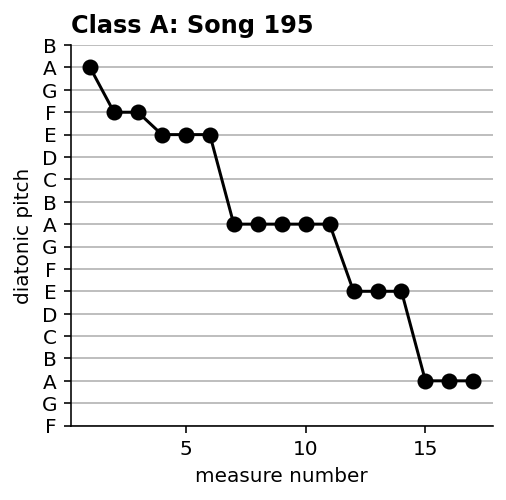

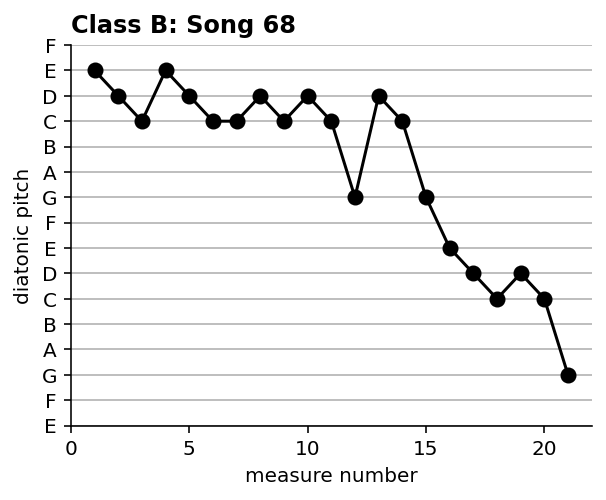

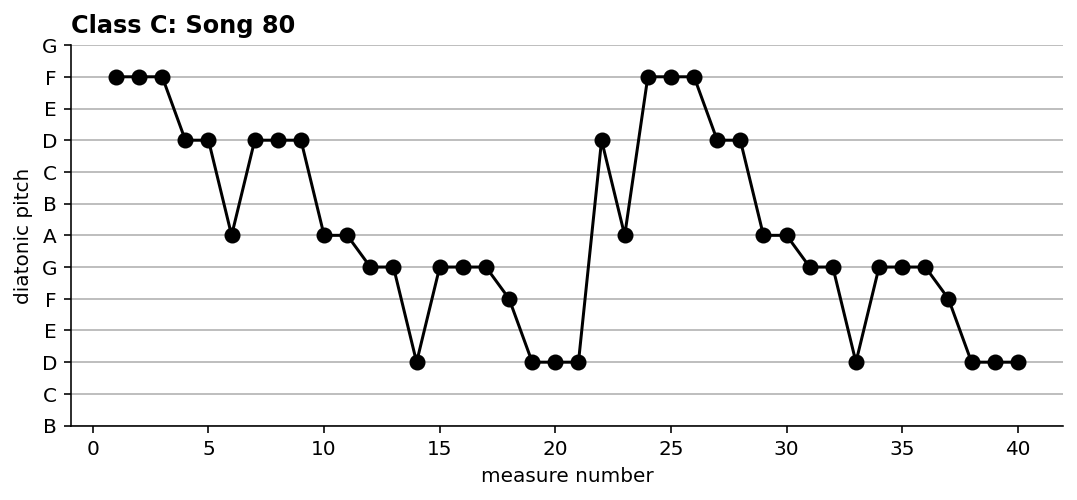

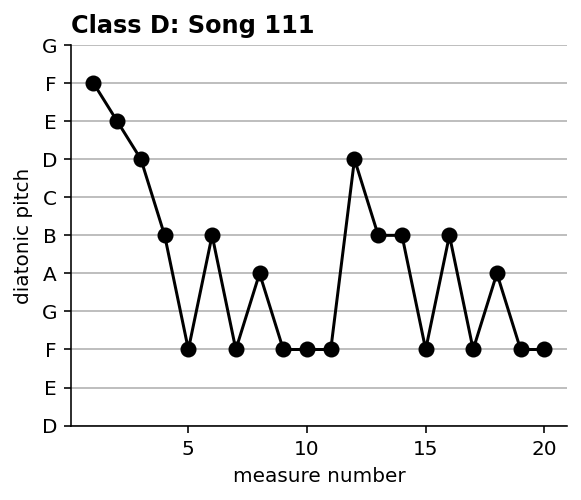

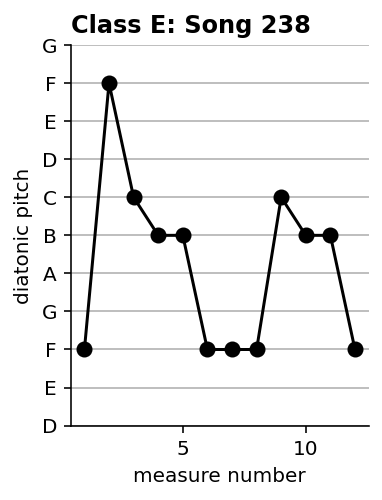

In [309]:
exemplars = dict(A=195, B=68, C=80, D=111, E=238)
for contour_class, song_num in exemplars.items():
    id = f'sioux{song_num:>03d}'
    xs, _, _ = densmore_contours[id]
    plt.figure(figsize=(len(xs)/4.5, 3.5))
    show_densmore_contour(id, diatonic=True, show_all_notes=False)
    title(f'Class {contour_class}: Song {song_num}')
    sns.despine()
    

### Comparison diatonic vs chromatic pitch

In [310]:
def show_diatonic_vs_chromatic(id):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
    plt.sca(ax0)
    show_densmore_contour(id, diatonic=False)
    title('Chromatic')
    sns.despine()

    plt.sca(ax1)
    show_densmore_contour(id, diatonic=True)
    title('Diatonic')
    plt.legend()
    sns.despine()
    
    plt.subplot(ax2, sharey=ax0)
    ys = raw_contours[id]
    plt.plot(np.linspace(0, 1, len(ys)), ys)
    title('Interpolated contour')
    plt.xlabel('relative position')
    plt.ylabel('MIDI pitch')

    plt.suptitle(f'Song {id}\n', fontweight='bold', y=1.05)

# show_diatonic_vs_chromatic('sioux001')

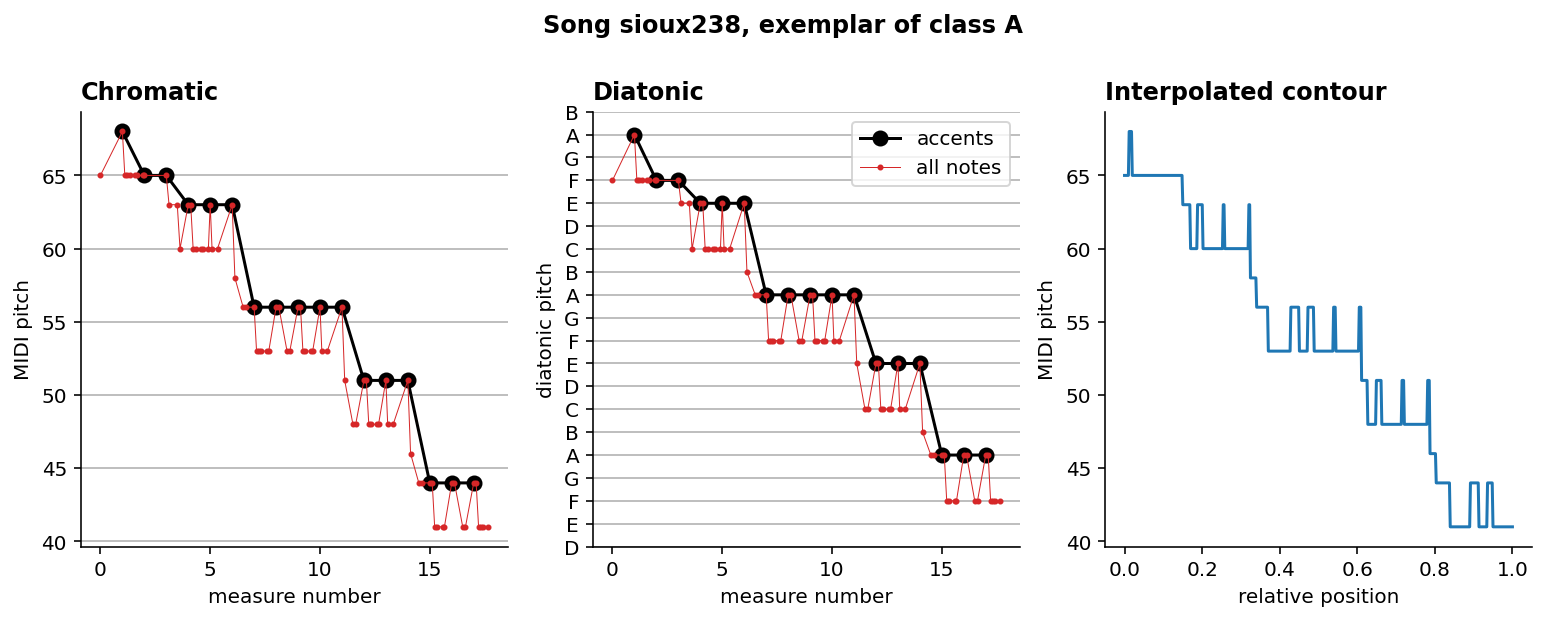

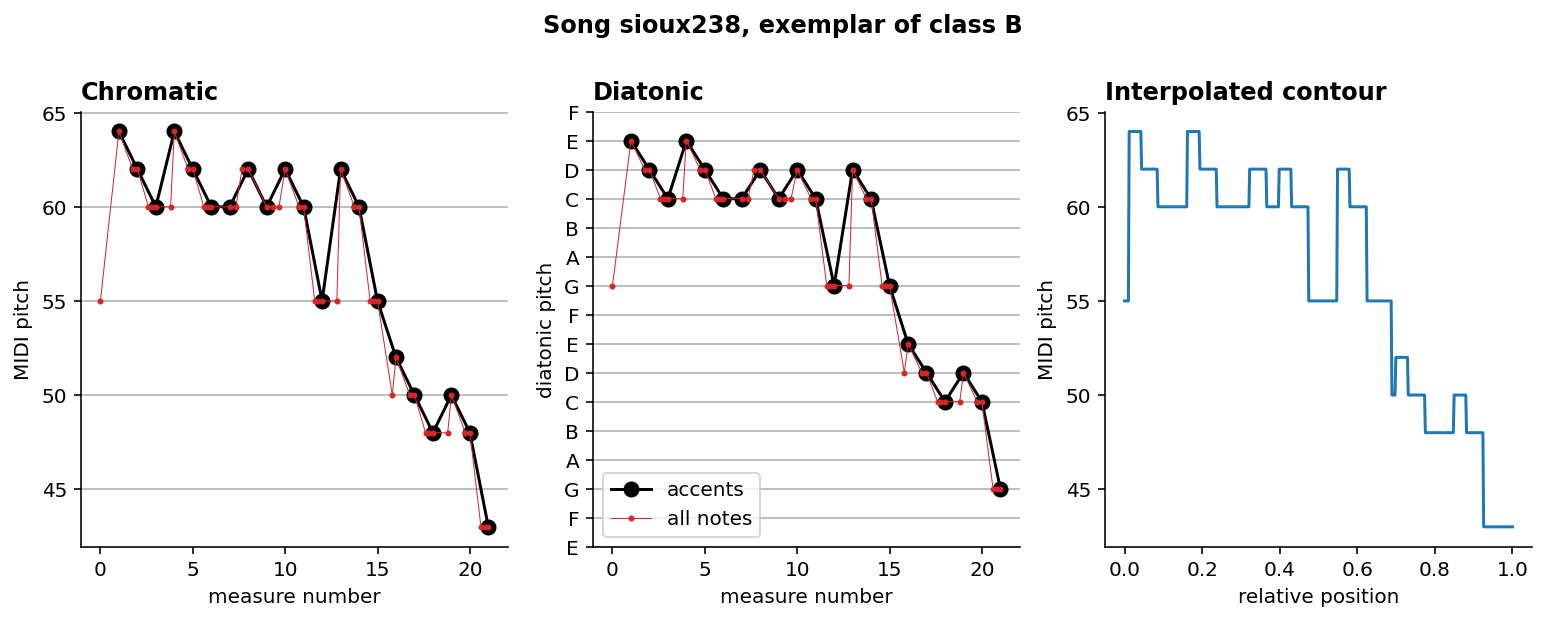

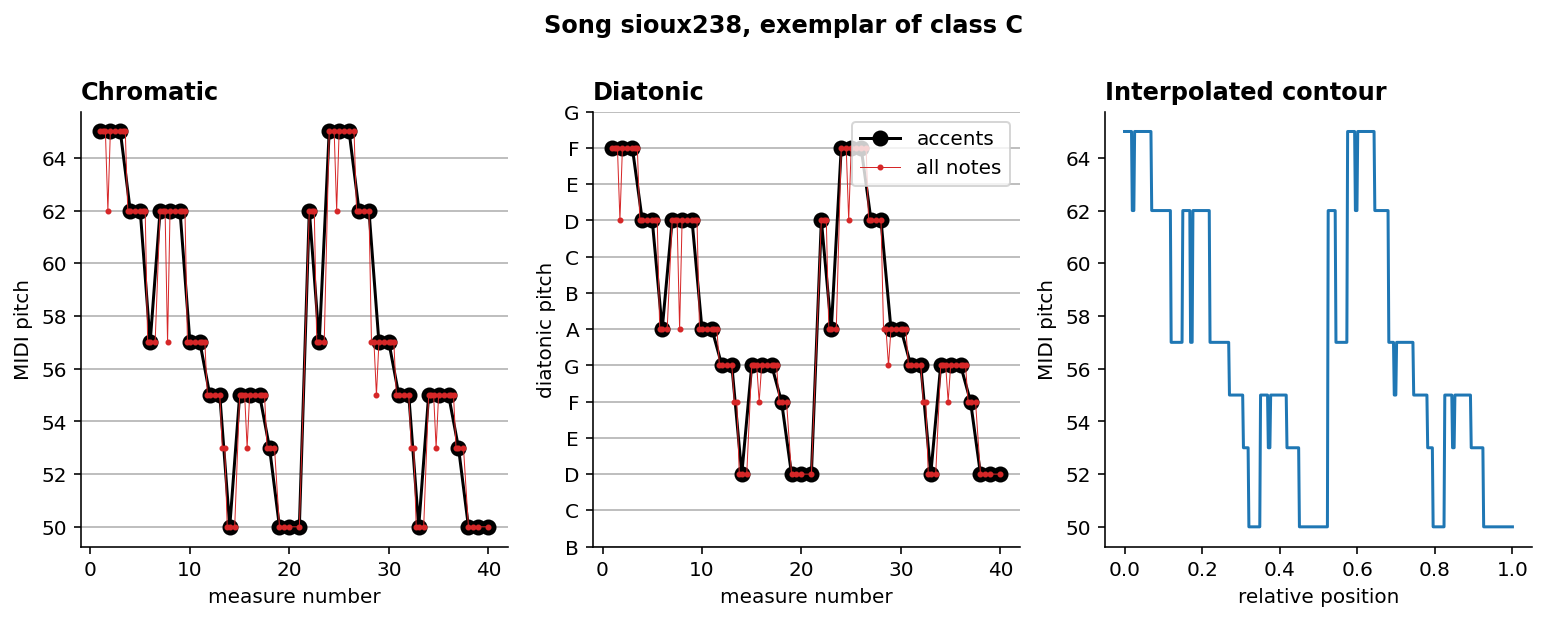

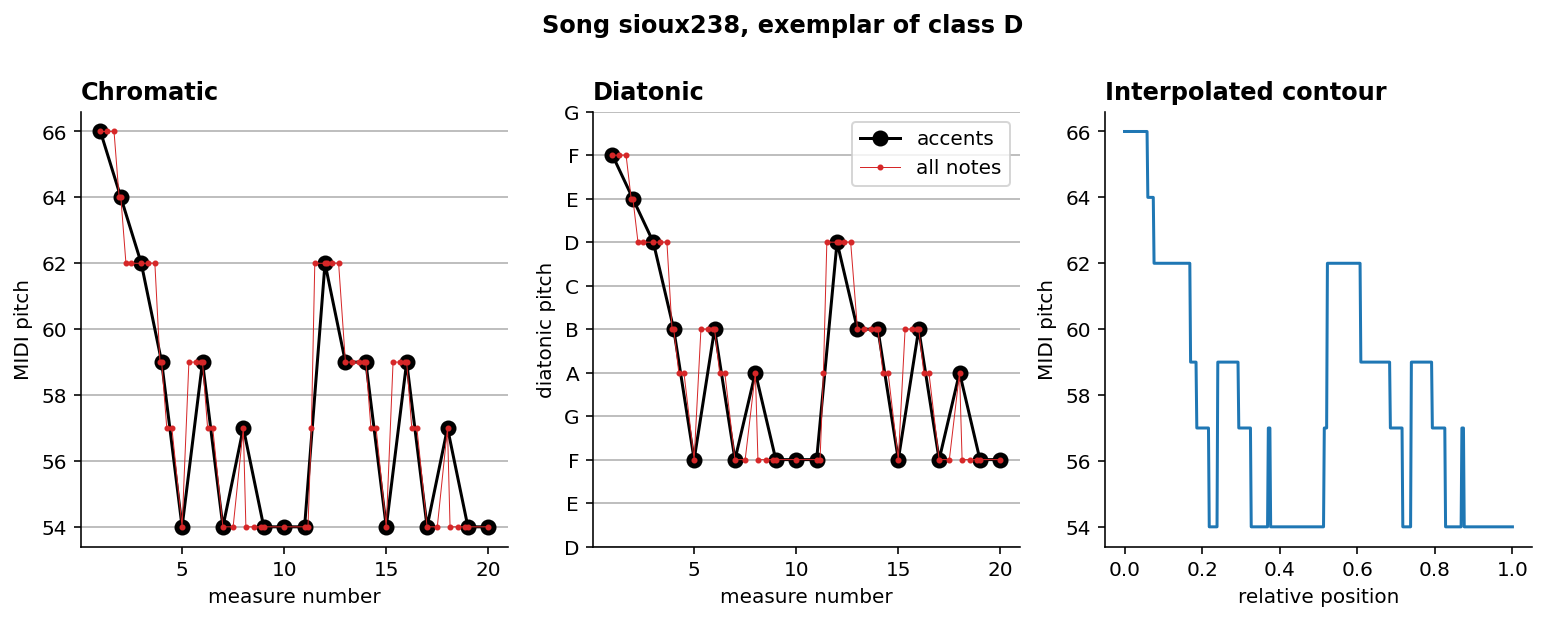

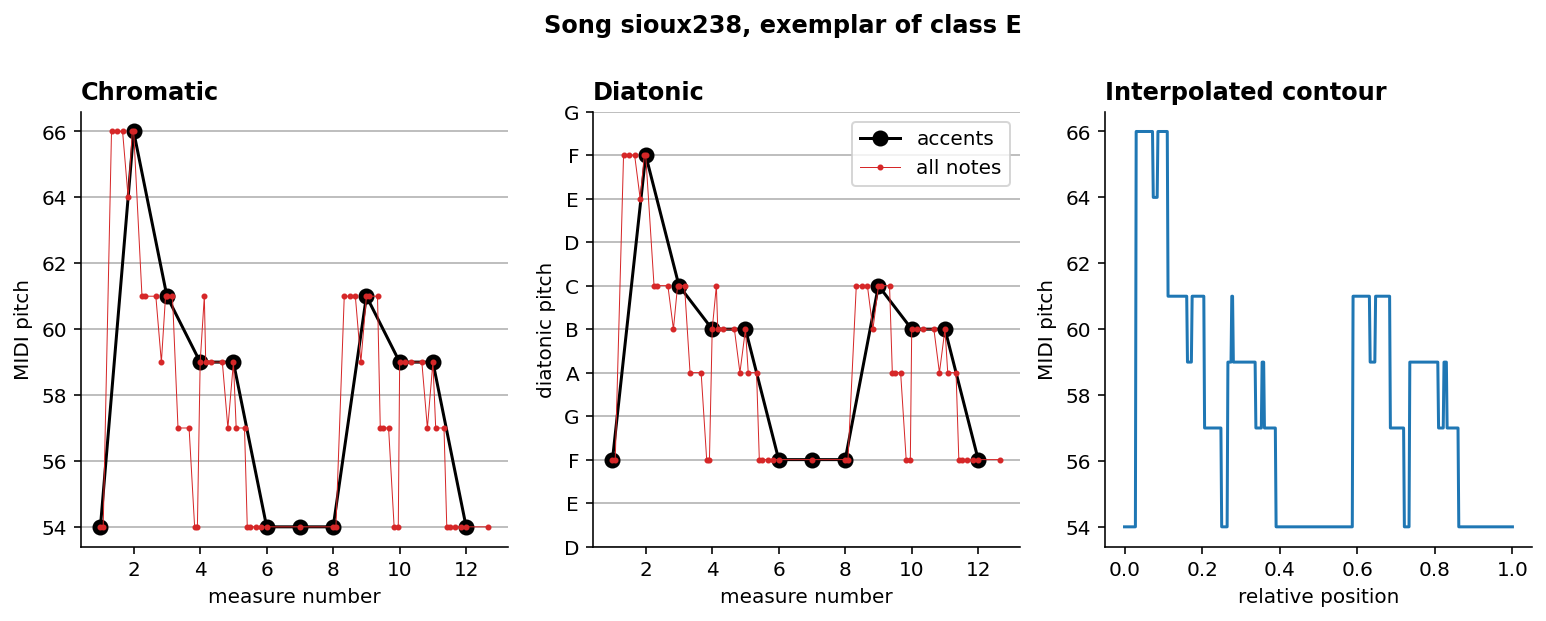

In [311]:
exemplars = dict(A=195, B=68, C=80, D=111, E=238)
for contour_class, song_num in exemplars.items():
    show_diatonic_vs_chromatic(f'sioux{song_num:>03d}')
    plt.suptitle(f'Song {id}, exemplar of class {contour_class}', fontweight='bold', y=1.05)

The difference between the diatonic and chromatic representation is small, so I'll be using the chromatic one since it's conceptually simpler.

## Plot per class

In [290]:
def find_tonic_near_final(tonic, contour, diatonic=False):
    """Return tonic closest to the final"""
    octave = 7 if diatonic else 12
    tonics = np.arange(tonic % octave, (tonic % octave + octave) * 10, octave)
    dist = np.abs(tonics - contour[-1])
    return tonics[dist.argmin()]

def find_tonic_in_contour(tonic, contour, diatonic=False):
    """Return the tonic that occurs in the contour"""
    octave = 7 if diatonic else 12
    tonics = np.arange(tonic % octave, (tonic % octave + octave) * 10, octave)
    intersection = np.intersect1d(contour, tonics)
    if len(intersection) == 0:
        return False
    else:
        return intersection.min()

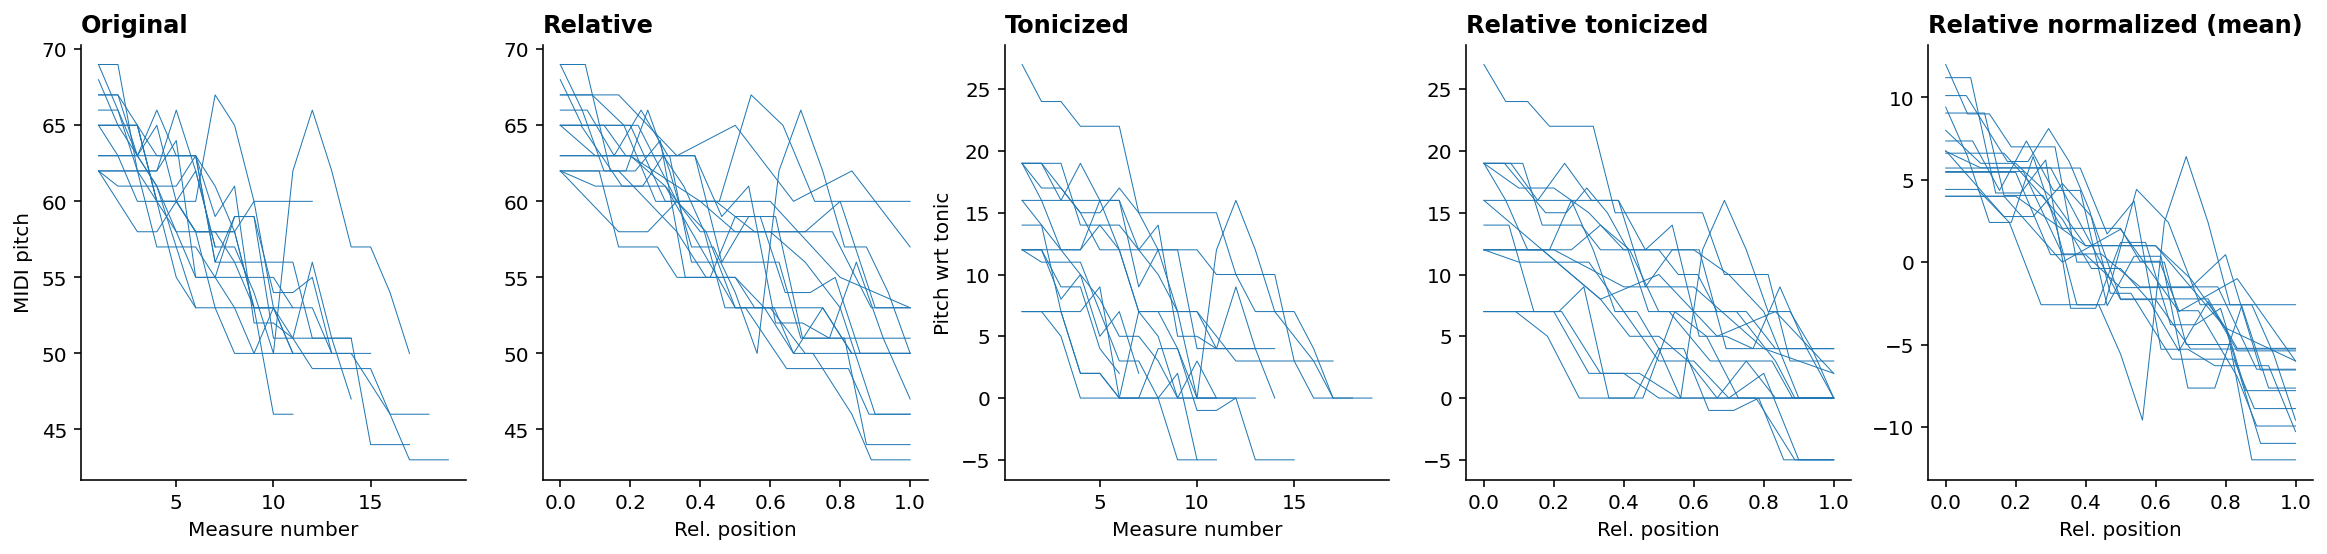

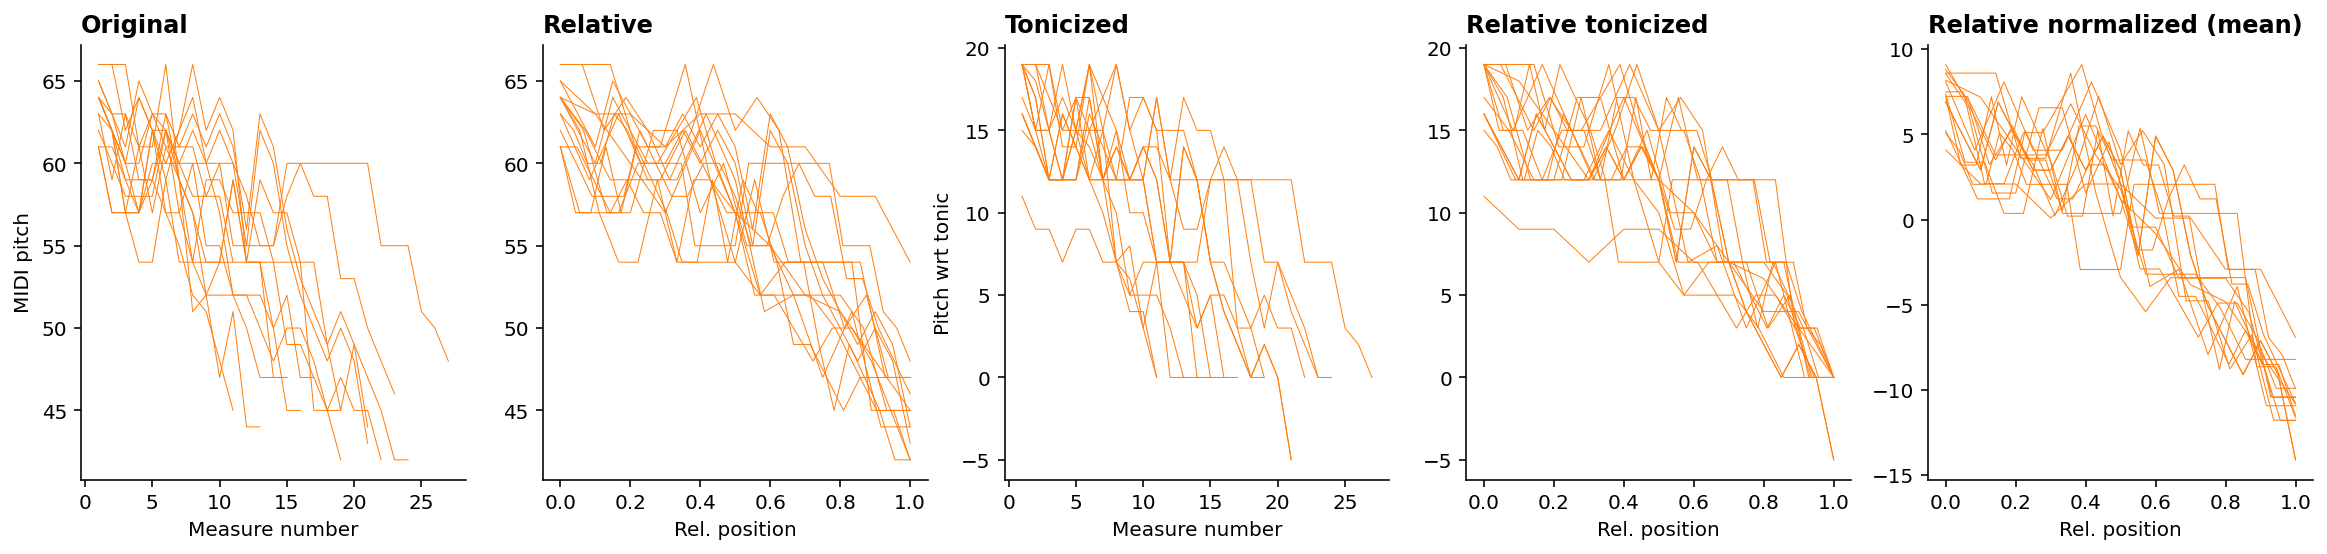

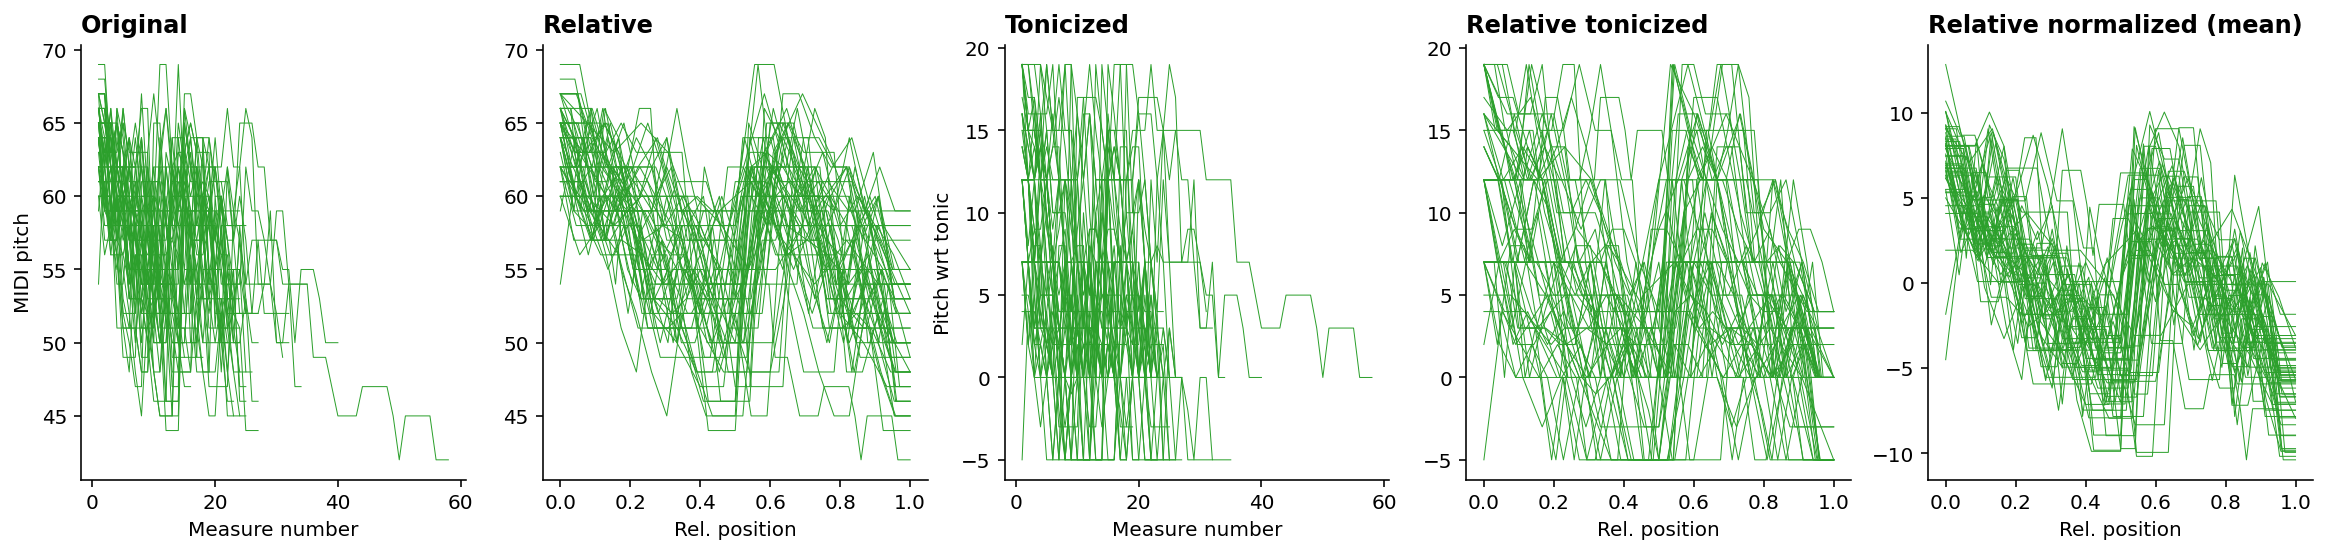

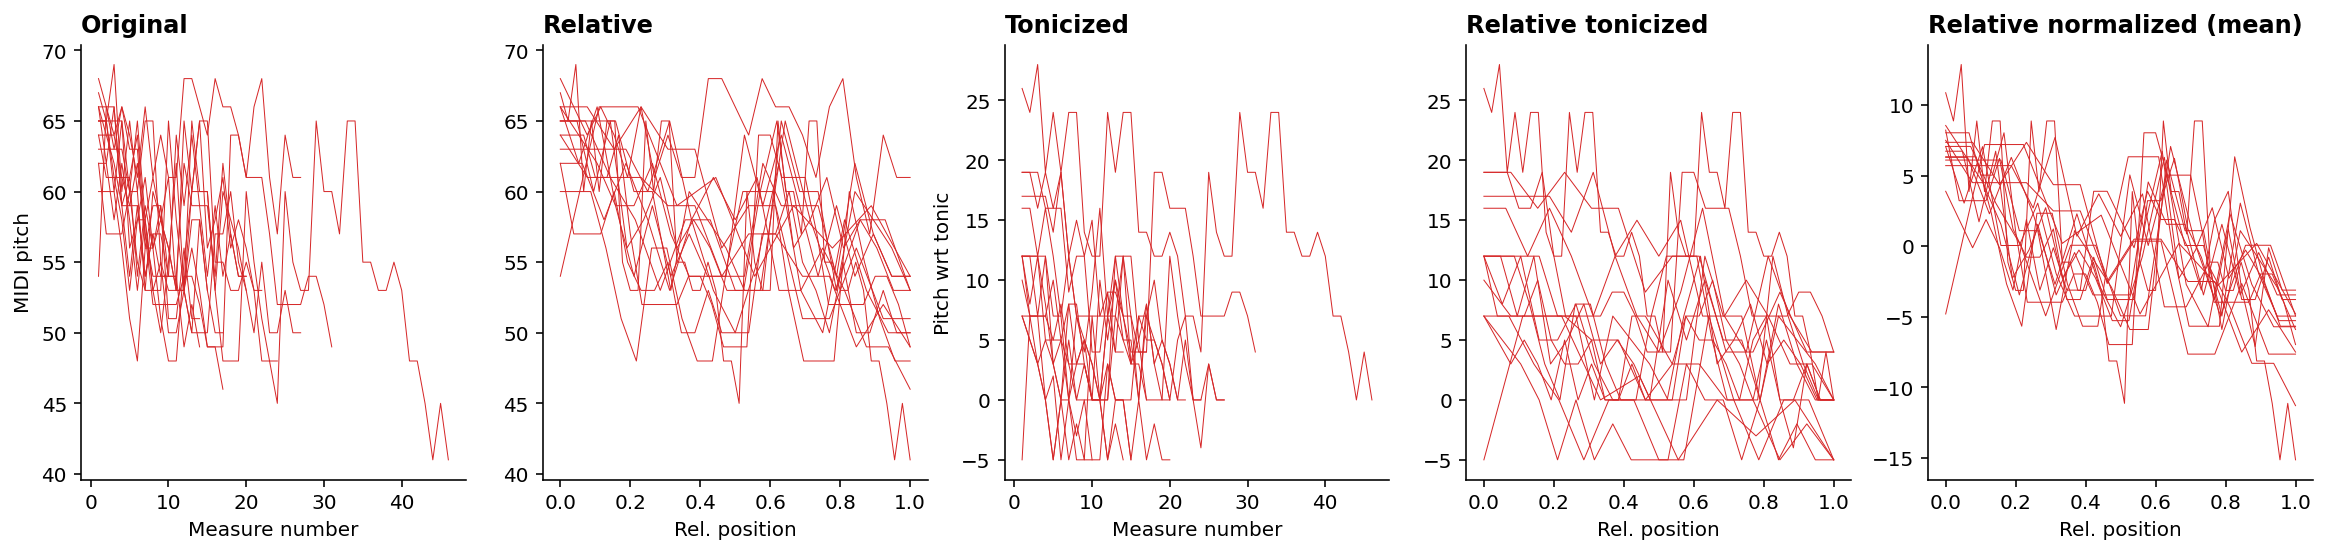

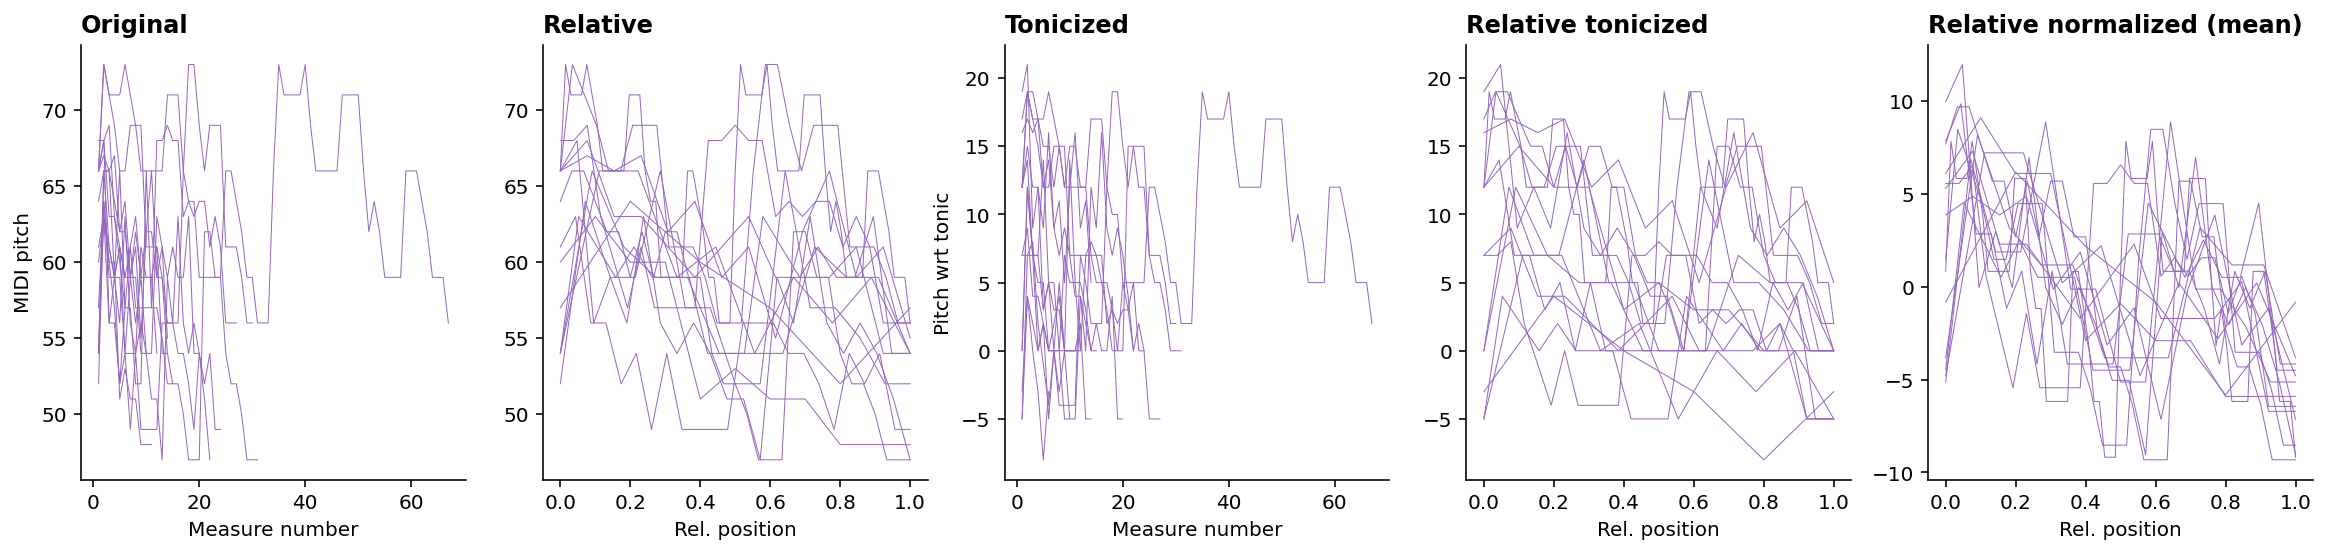

In [338]:

diatonic = False
for i, cls in enumerate('ABCDE'):
    subset = index[index.contour_classes.str.contains(cls) == True]
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    kwargs = dict(lw=0.5, c=f'C{i}')
    for id, info in subset.iterrows():
        if id == 'sioux165': continue

        xs, ys_chromatic, ys_diatonic = densmore_contours[id]
        ys = ys_diatonic if diatonic else ys_chromatic

        raw_tonic = info['tonic_diatonic'] if diatonic else info['tonic_chromatic']
        if find_tonic_in_contour(raw_tonic, ys, diatonic=diatonic) == False:
            print('Tonic not in contour', info['tonality'], raw_tonic, id)

        tonic = find_tonic_near_final(raw_tonic, ys, diatonic=diatonic)

        plt.sca(axs[0])
        plt.plot(xs, ys,  **kwargs)
        plt.ylabel('MIDI pitch')
        plt.xlabel('Measure number')
        title('Original')
        
        plt.subplot(axs[1], sharey=axs[0])
        plt.plot(np.linspace(0, 1, len(ys)), ys, **kwargs)
        plt.xlabel('Rel. position')
        title('Relative')

        plt.subplot(axs[2])        
        plt.plot(xs, ys - tonic,  **kwargs)
        plt.ylabel('Pitch wrt tonic')
        plt.xlabel('Measure number')
        title('Tonicized')

        plt.subplot(axs[3], sharey=axs[2])
        plt.plot(np.linspace(0, 1, len(ys)), ys - tonic,  **kwargs)
        plt.xlabel('Rel. position')
        title('Relative tonicized')

        plt.subplot(axs[4], sharey=axs[2])
        plt.plot(np.linspace(0, 1, len(ys)), ys - ys.mean(),  **kwargs)
        plt.xlabel('Rel. position')
        title('Relative normalized (mean)')

    for ax in axs: sns.despine(ax=ax)

### Compare classes

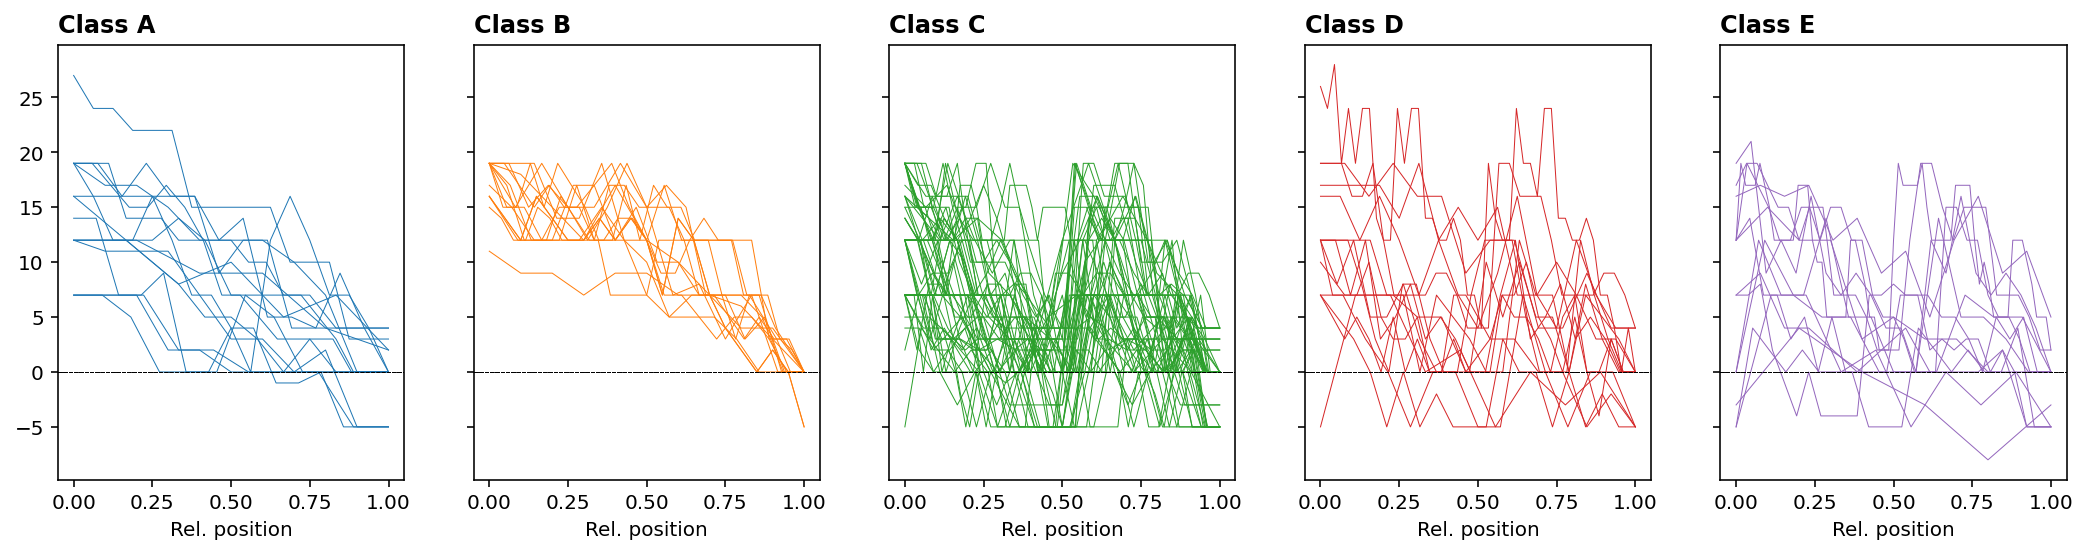

In [334]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)

for i, cls in enumerate('ABCDE'):
    subset = index[index.contour_classes.str.contains(cls) == True]
    kwargs = dict(lw=0.5, c=f'C{i}')
    plt.subplot(axs[i])
    for id, info in subset.iterrows():
        if id == 'sioux165': continue
        xs, ys, _ = densmore_contours[id]
        
        raw_tonic = info['tonic_chromatic']
        if find_tonic_in_contour(raw_tonic, ys, diatonic=False) == False:
            print('Tonic not in contour', info['tonality'], raw_tonic, id)
        tonic = find_tonic_near_final(raw_tonic, ys, diatonic=False)

        plt.plot(np.linspace(0, 1, len(ys)), ys - tonic,  **kwargs)
        plt.xlabel('Rel. position')

        plt.axhline(0, ls='--', c='k', lw=.5)
        title(f'Class {cls}')

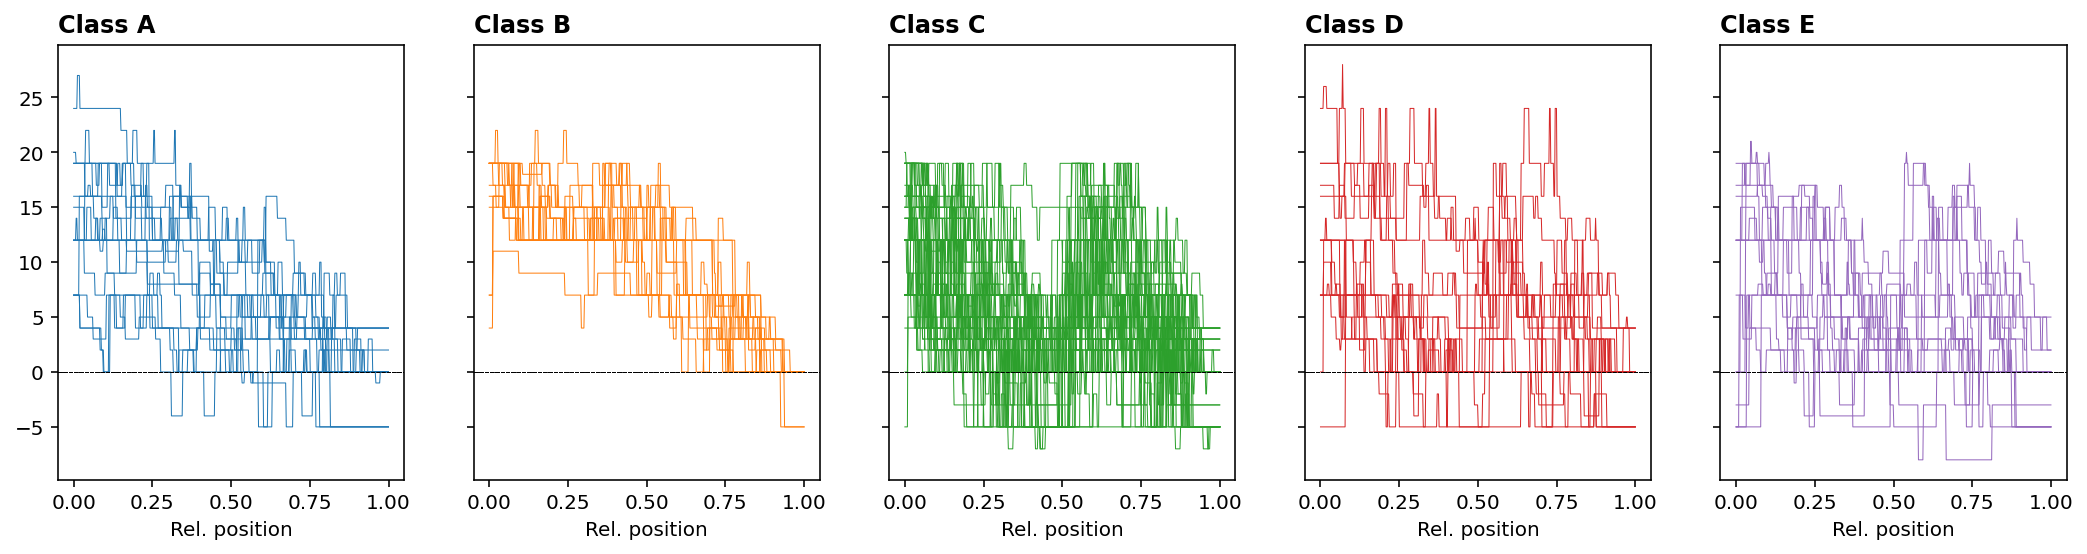

In [344]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)

for i, cls in enumerate('ABCDE'):
    subset = index[index.contour_classes.str.contains(cls) == True]
    kwargs = dict(lw=0.5, c=f'C{i}')
    plt.subplot(axs[i])
    for id, info in subset.iterrows():
        if id not in raw_contours: continue
        ys = raw_contours[id]
        
        raw_tonic = info['tonic_chromatic']
        if find_tonic_in_contour(raw_tonic, ys, diatonic=False) == False:
            print('Tonic not in contour', info['tonality'], raw_tonic, id)
        tonic = find_tonic_near_final(raw_tonic, ys, diatonic=False)

        plt.plot(np.linspace(0, 1, len(ys)), ys - tonic,  **kwargs)
        plt.xlabel('Rel. position')

        plt.axhline(0, ls='--', c='k', lw=.5)
        title(f'Class {cls}')

### Barycenters

In [345]:
from tslearn.barycenters import softdtw_barycenter, dtw_barycenter_averaging

In [375]:
def interpolate(xs, ys, N=500, kind='previous'):
    func = scipy.interpolate.interp1d(xs, ys, kind=kind)
    new_ys = func(np.linspace(min(xs), max(xs), N))
    return new_ys

In [400]:
interpolated_densmore_contours = {}
for id, (xs, ys, _) in densmore_contours.items():
    try:
        raw_tonic = index.loc[id, 'tonic_chromatic']
        tonic = find_tonic_near_final(raw_tonic, ys, diatonic=False)
        new_ys = interpolate(xs, ys-tonic, N=200)
        interpolated_densmore_contours[id] = new_ys   
    except Exception as e:
        print(id, e)

sioux108 arange: cannot compute length
sioux166 arange: cannot compute length


### Densmore contours

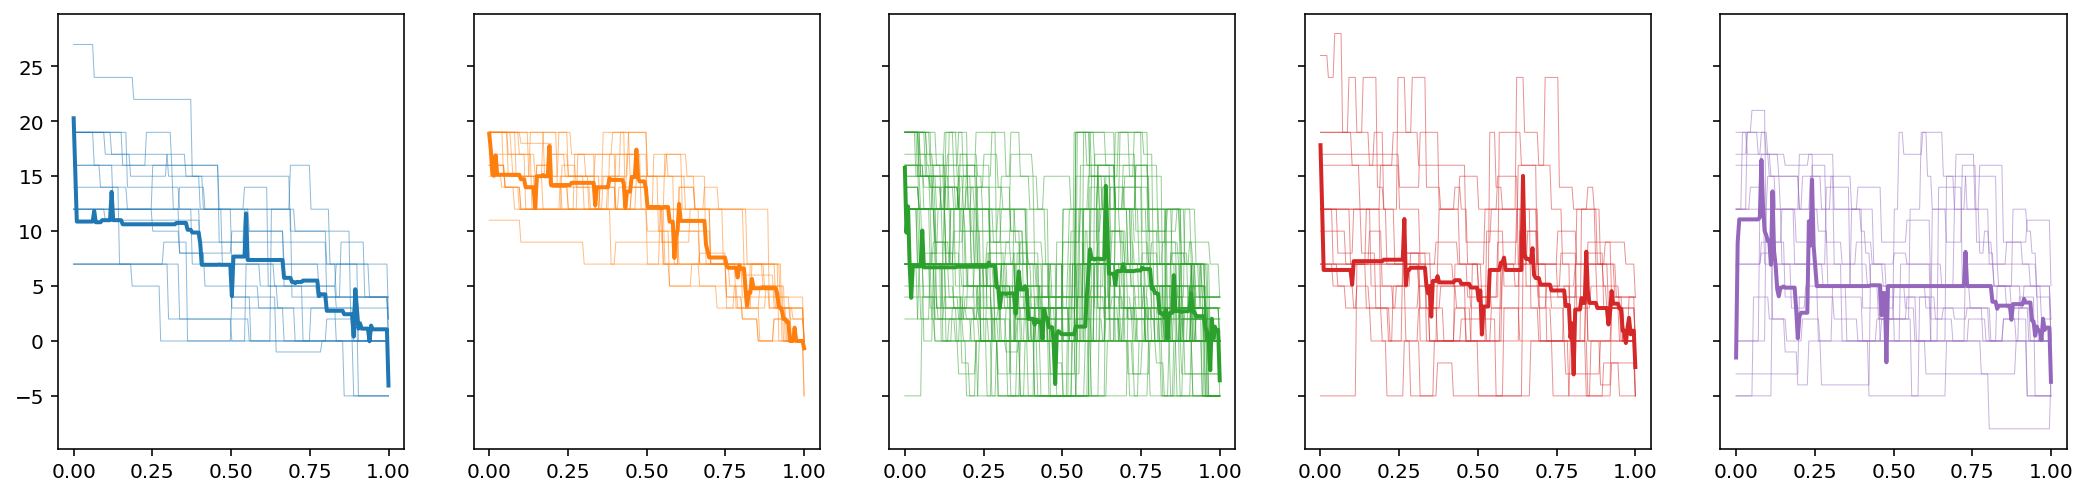

In [401]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
for i, cls in enumerate('ABCDE'):
    plt.subplot(axs[i])
    subset = index[index.contour_classes.str.contains(cls) == True]
    X = np.array([interpolated_densmore_contours[id] for id in subset.index if id not in ['sioux165', 'sioux108', 'sioux166']])
    barycenter = dtw_barycenter_averaging(X)
    xs = np.linspace(0, 1, X.shape[1])
    plt.plot(xs, barycenter, lw=2, c=f'C{i}')
    plt.plot(xs, X.T, lw=.5, c=f'C{i}', alpha=.5)

### Raw contours

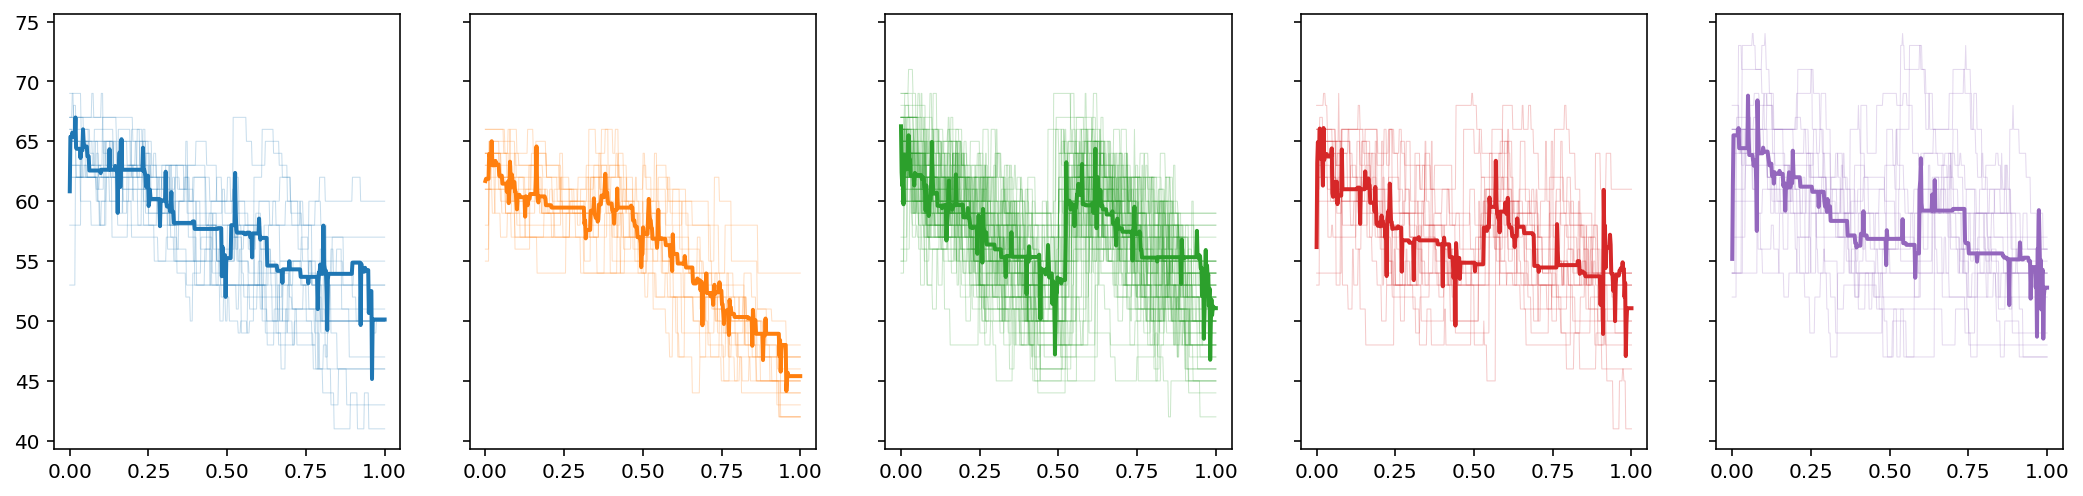

In [404]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
for i, cls in enumerate('ABCDE'):
    plt.subplot(axs[i])
    subset = index[index.contour_classes.str.contains(cls) == True]
    X = np.array([raw_contours[id] for id in subset.index if id not in ['sioux175']])
    barycenter = dtw_barycenter_averaging(X)
    xs = np.linspace(0, 1, X.shape[1])
    plt.plot(xs, barycenter, lw=2, c=f'C{i}')
    plt.plot(xs, X.T, lw=.5, c=f'C{i}', alpha=.25)

In [407]:
from tslearn.barycenters import softdtw_barycenter, dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [423]:
init = np.array([interpolated_densmore_contours[f'sioux{id:>03d}'] for id in exemplars.values()])[:, :, np.newaxis]
X = np.array(list(interpolated_densmore_contours.values()))

In [425]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", init=init)
labels = km.fit_predict(X)

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 242 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


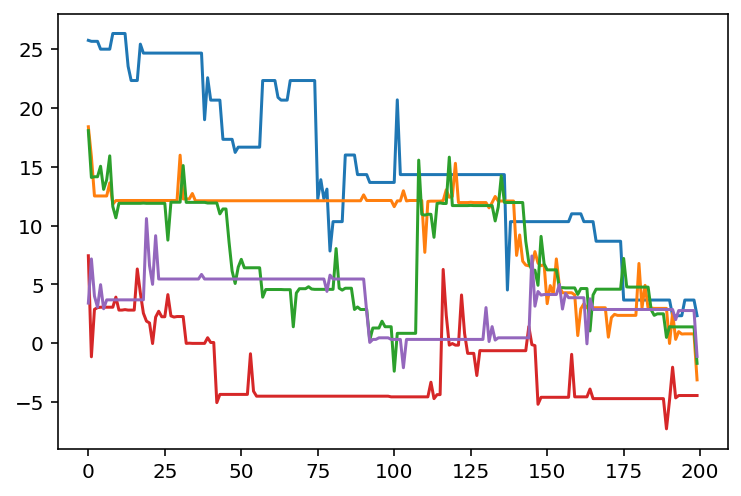

In [426]:
plt.plot(km.cluster_centers_[:, :, 0].T)

In [427]:
from tslearn.neighbors import KNeighborsTimeSeries
knn = KNeighborsTimeSeries(n_neighbors=2)
knn.fit(X)

KNeighborsTimeSeries(metric='dtw', metric_params=None, n_jobs=None,
                     n_neighbors=2, verbose=0)

In [439]:
knn.kneighbors?

Signature: knn.kneighbors(X=None, n_neighbors=None, return_distance=True)
Docstring:
Finds the K-neighbors of a point.

Returns indices of and distances to the neighbors of each point.

Parameters
----------
X : array-like, shape (n_ts, sz, d)
    The query time series.
    If not provided, neighbors of each indexed point are returned.
    In this case, the query point is not considered its own neighbor.
n_neighbors : int
    Number of neighbors to get (default is the value passed to the
    constructor).
return_distance : boolean, optional. Defaults to True.
    If False, distances will not be returned

Returns
-------
dist : array
    Array representing the distance to points, only present if
    return_distance=True
ind : array
    Indices of the nearest points in the population matrix.
File:      ~/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/neighbors/neighbors.py
Type:      method


In [436]:
knn._X_fit.shape

(242, 242)

In [435]:
# subset = index[index.contour_classes.str.contains(cls) == True]
# = np.array([raw_contours[id] for id in subset.index if id not in ['sioux175']])
X2 = np.array([interpolated_densmore_contours['sioux195']])

knn.kneighbors(X2)

ValueError: Dimensions of the provided timeseries(except first) must match those of the fitted data! ((242, 242) and (1, 200) are passed shapes)

## Normalize wrt tonic or final

In [523]:
normalized_contours = {}
for idx, row in index.iterrows():
    if idx == 'sioux165': continue
    contour = contours[idx]
    normalized_contours[idx] = contour - contour[-1]

In [524]:
tonicized_contours = {}
for idx, row in index.iterrows():
    if idx == 'sioux165': continue
    contour = contours[idx]
    tonic = row['tonic']
    tonics = np.arange(tonic % 7, (tonic % 7 + 7) * 10, 7)
    intersection = np.intersect1d(contour, tonics)
    if len(intersection) == 0:
        print(idx, tonics, contour)
    tonicized_contours[idx] = contour - intersection.min()

sioux064 [ 3. 10. 17. 24. 31. 38. 45. 52. 59. 66. 73. 80. 87. 94.] [30 29 28 28 28 30 29 28 28 29 29 28 26 26 28 29 28 28 25 25 23 22 21]


ValueError: zero-size array to reduction operation minimum which has no identity

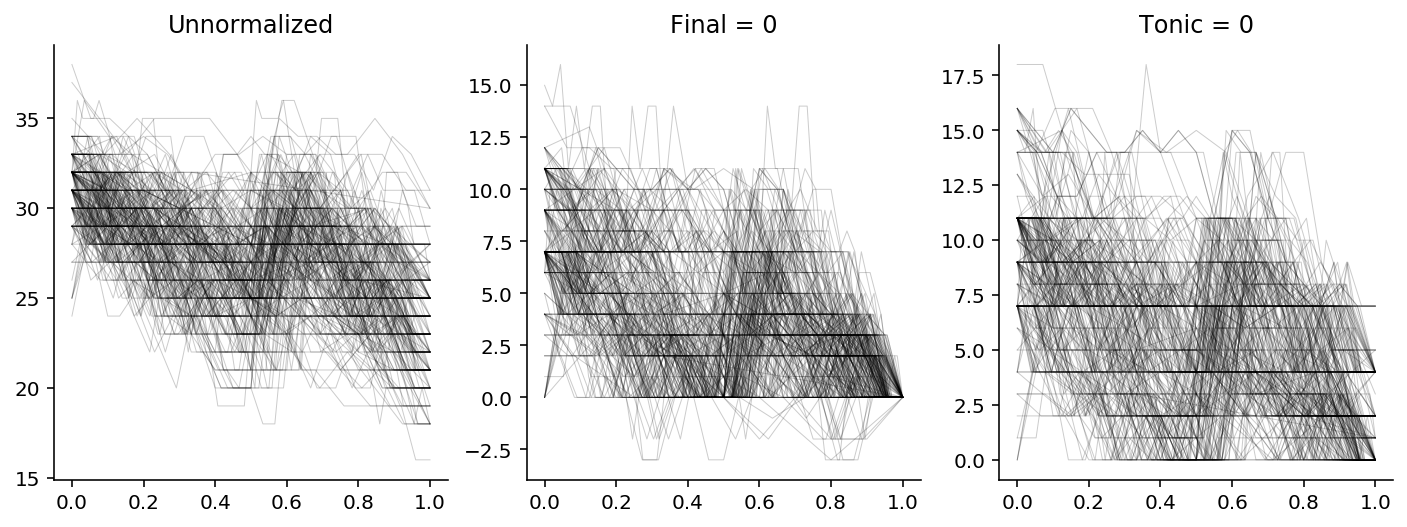

In [488]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))

for idx, contour in contours.items():
    xs = np.linspace(0, 1, len(contour))
    ax0.plot(xs, contour, 'k-', alpha=.2, lw=.5)
ax0.set_title('Unnormalized')

for idx, contour in normalized_contours.items():
    xs = np.linspace(0, 1, len(contour))
    ax1.plot(xs, contour, 'k-', alpha=.2, lw=.5)
ax1.set_title('Final = 0')

for idx, contour in tonicized_contours.items():
    xs = np.linspace(0, 1, len(contour))
    ax2.plot(xs, contour, 'k-', alpha=.2, lw=.5)
ax2.set_title('Tonic = 0')

sns.despine(ax=ax0)
sns.despine(ax=ax1)
sns.despine(ax=ax2)

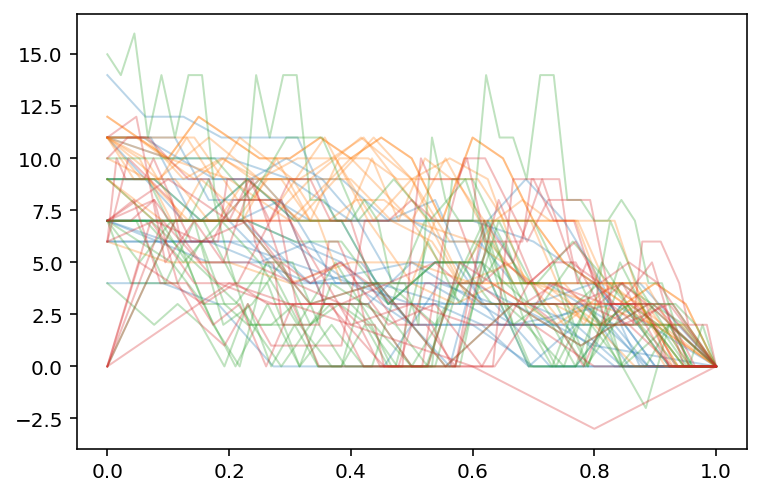

In [328]:
for i, cls in enumerate('ABDE'):
    subset = index[index.contour_class.str.contains(cls) == True]
    for idx in subset.index:
        try:
            contour = normalized_contours[idx]
            xs = np.linspace(0, 1, len(contour))
            plt.plot(xs, contour, '-', alpha=.3, lw=1, color=f'C{i}')
        except: 
            continue


In [ ]:
index[index.contour_class.str.contains('A') == True].index

## Clustering

In [383]:
def interpolate_contours(contours, N=50):
    X = []
    xs = np.linspace(0, 1, N)
    for idx, contour in contours.items():
        contour = np.r_[contour, contour[-1]]
        func = scipy.interpolate.interp1d( 
            np.linspace(0, 1, len(contour)),
            contour,
            kind='previous'
        )
        X.append(func(xs))
    return np.array(X)

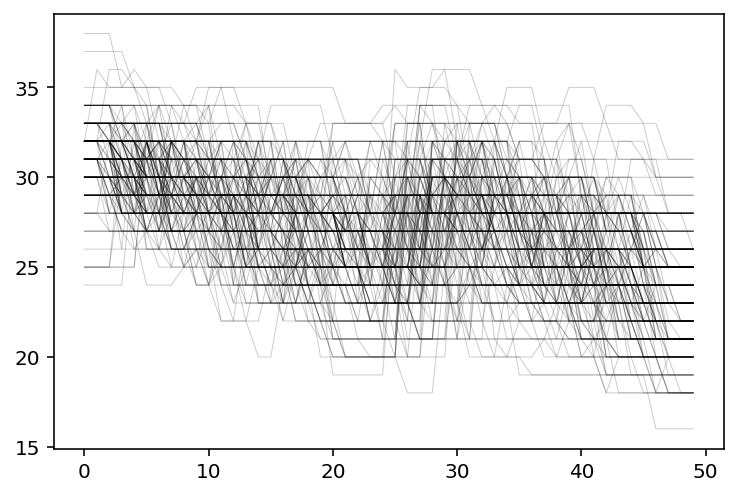

In [384]:
X =  interpolate_contours(contours)
plt.plot(X.T, 'k-', lw=.5, alpha=.2);

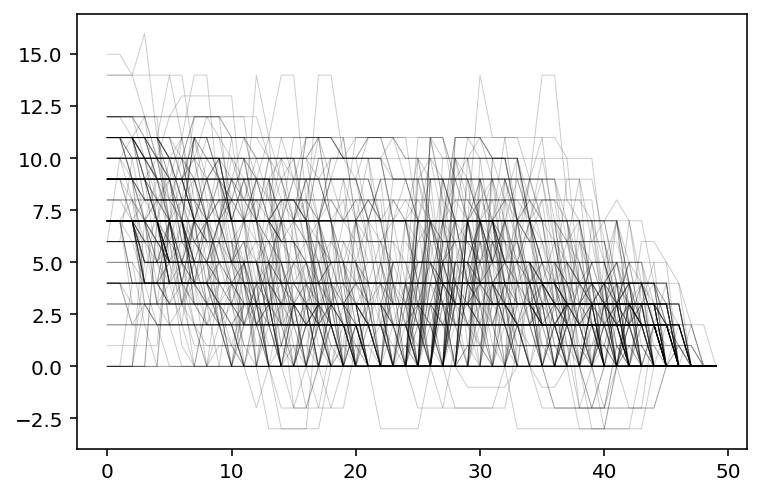

In [391]:
X_norm =  interpolate_contours(normalized_contours)
plt.plot(X_norm.T, 'k-', lw=.5, alpha=.2);

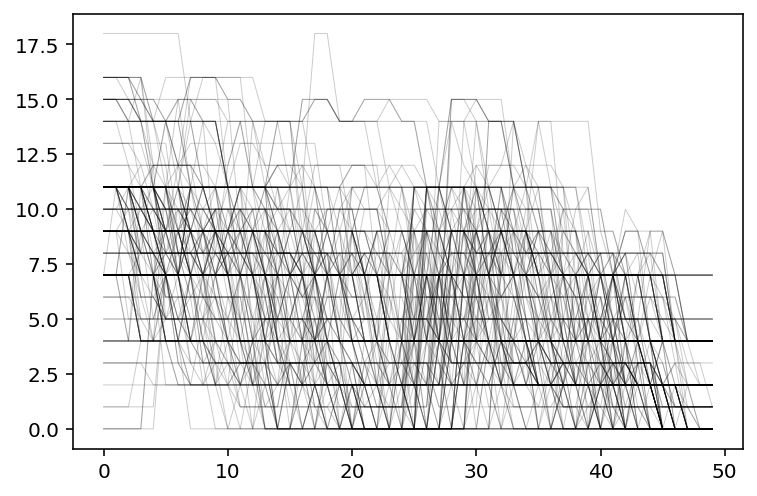

In [390]:
X_tonic =  interpolate_contours(tonicized_contours)
plt.plot(X_tonic.T, 'k-', lw=.5, alpha=.2);

In [427]:
import tslearn
from tslearn.barycenters import softdtw_barycenter, dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

from tslearn.clustering import KShape


Index(['sioux030', 'sioux056', 'sioux059', 'sioux070', 'sioux071', 'sioux079',
       'sioux086', 'sioux091', 'sioux101', 'sioux120', 'sioux151a',
       'sioux151b', 'sioux152', 'sioux195', 'sioux210', 'sioux215'],
      dtype='object', name='id')

In [409]:
km = TimeSeriesKMeans(n_clusters=5, metric="softdtw")
labels = km.fit_predict(X_norm)
# km_bis = TimeSeriesKMeans(n_clusters=2, metric="softdtw")
# labels_bis = km_bis.fit_predict(X)

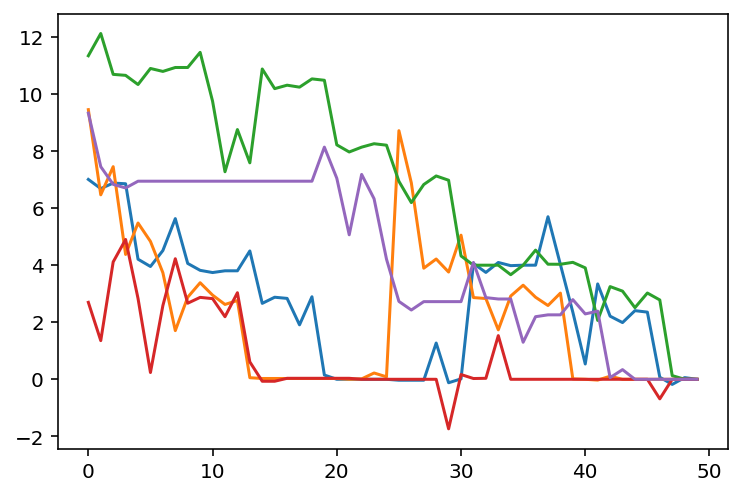

In [456]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw")
labels = km.fit_predict(X_norm)
plt.plot(km.cluster_centers_[:, :, 0].T)

In [457]:
barycenters = []
for i in range(5):
    bar = dtw_barycenter_averaging(X_norm[labels == i])
    barycenters.append(bar)

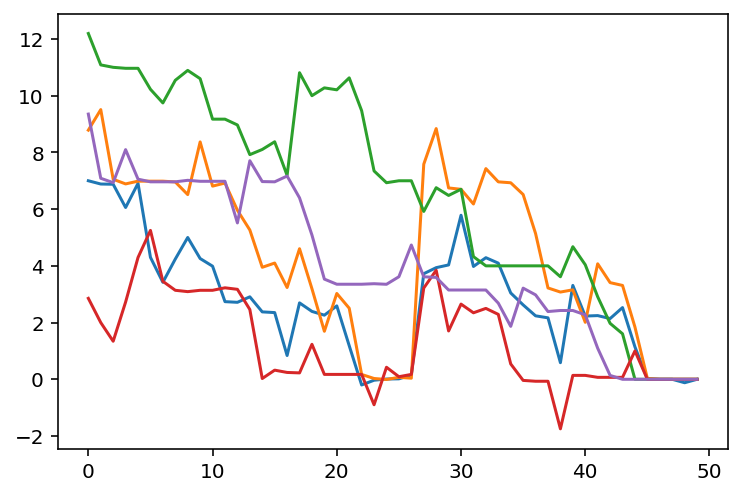

In [458]:
for i in range(5):    
    plt.plot(barycenters[i], c=f'C{i}')

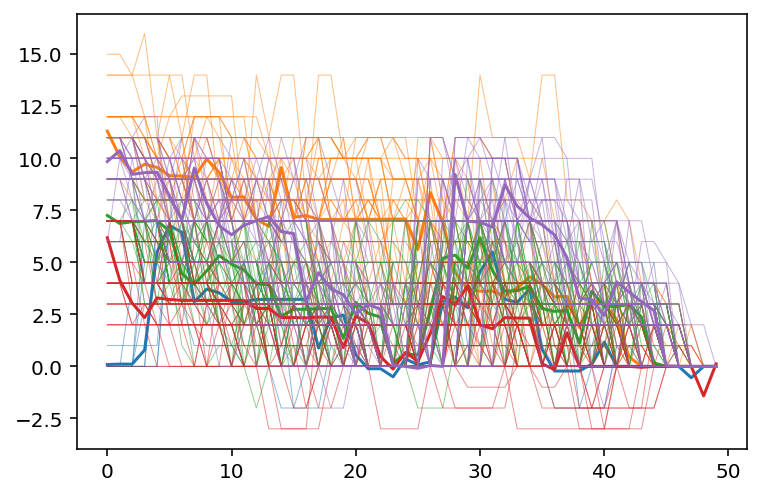

In [425]:
for i in range(5):    
    plt.plot(X_norm[labels == i, :].T, c=f'C{i}', alpha=.5, lw=.5);
    plt.plot(barycenters[i], c=f'C{i}')

In [ ]:
gak_km = KernelKMeans(n_clusters=2, kernel="gak")
labels_gak = gak_km.fit_predict(X)

In [395]:
bar_tonic = softdtw_barycenter(X_tonic, max_iter=50, gamma=1)
plt.plot(bar_tonic)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)